In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from scipy.optimize import minimize, leastsq  # for the minimizer in part 1
from mpl_toolkits.mplot3d import Axes3D

## Set up functions

In [2]:
train_pts = (np.pi/10) * np.linspace(0, 5, 6)
g = lambda x : 1 - np.cos(x)
relu = lambda x : np.maximum(x, 0)
relup = lambda x : np.where(x <= 0, 0, 1)
f = lambda a, b : ((relu(a*train_pts - b) - g(train_pts))**2).sum()/12

def gradf(a, b):
    out = np.zeros((2,))
    out[0] = (1/6)*sum((relu(a*train_pts - b) - g(train_pts))*relup(a*train_pts - b)*train_pts)
    out[1] =-(1/6)*sum((relu(a*train_pts - b) - g(train_pts))*relup(a*train_pts - b))
    return out

def hessf(a, b):
    out = np.zeros((2, 2))
    relup2 = relup(a*train_pts - b)**2
    out[0, 0] = (train_pts**2*relup2).sum()
    out[0, 1] = out[1, 0] = -(train_pts*relup2).sum()
    out[1, 1] = relup2.sum()
    return out/6

## Part 1

In [3]:
# get grad vals and f vals
a = b = np.linspace(-5, 5)
AA, BB = np.meshgrid(a, b)
f_vals = np.zeros((a.shape[0], b.shape[0]))
grad_vals = np.zeros((a.shape[0], b.shape[0], 2))
for i in range(grad_vals.shape[0]):
    for j in range(grad_vals.shape[1]):
        f_vals[i, j] = f(AA[i, j], BB[i, j])
        grad_vals[i, j, :] = gradf(AA[i, j], BB[i, j])

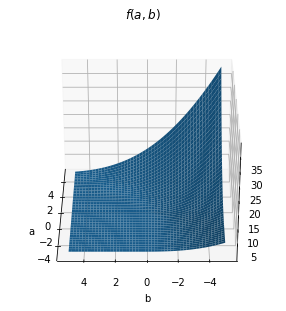

In [4]:
ax = plt.figure(figsize=(5,5)).add_subplot(111, projection='3d')
ax.plot_surface(AA, BB, f_vals)
ax.set_xlabel('a'); ax.set_ylabel('b')
ax.view_init(azim=180)
plt.title(r'$f(a,b)$')
plt.savefig('../pics/loss_surface.png')
plt.show()

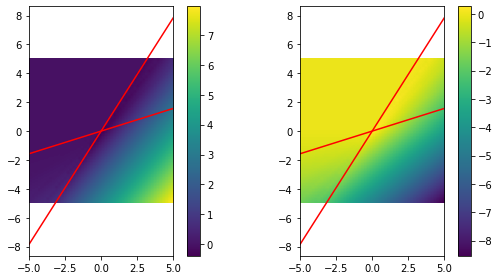

In [14]:
_, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
c1 = ax1.imshow(np.flip(grad_vals[:, :, 0], axis=0), extent=[-5,5,-5,5])
ax1.plot(a, (np.pi/2)*a, 'r')
ax1.plot(a, (np.pi/10)*a, 'r')
#ax1.scatter(m[0], m[1], c='r')
plt.colorbar(c1, ax=ax1)
c2 = ax2.imshow(np.flip(grad_vals[:, :, 1], axis=0), extent=[-5,5,-5,5])
ax2.plot(a, (np.pi/2)*a, 'r')
ax2.plot(a, (np.pi/10)*a, 'r')
#ax2.scatter(m[0], m[1], c='r')
plt.colorbar(c2, ax=ax2)
plt.tight_layout()
plt.show()

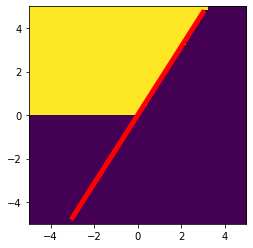

In [6]:
tol = 1e-5
zidxs = np.logical_and(abs(grad_vals[:, :, 0]) < tol, abs(grad_vals[:, :, 1]) < tol)
plt.imshow(np.flip(zidxs, axis=0), extent=[-5, 5, -5, 5])
plt.plot(np.linspace(-3, 3), (np.pi/2)*np.linspace(-3, 3), 'r', linewidth=5)
plt.savefig('../pics/flat_region.png')
plt.show()
# why is it not 0 at the minimizer?? i guess it just didn't evaluate there

In [7]:
# Find where Hessian is negative and positive definite
a = b = np.linspace(-5, 5)
AA, BB = np.meshgrid(a, b)
hess_vals = np.zeros((a.shape[0], b.shape[0], 2))
for i in range(hess_vals.shape[0]):
    for j in range(hess_vals.shape[1]):
        hess_vals[i, j, :] = np.linalg.eig(hessf(AA[i, j], BB[i, j]))[0]

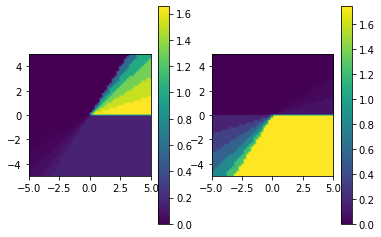

In [13]:
_, (ax1, ax2) = plt.subplots(ncols=2)
c1 = ax1.imshow(np.flip(hess_vals[:,:,0], axis=0), extent=[-5,5,-5,5])
#ax1.plot(a, -(np.pi/2)*a, 'r', a, -(np.pi/10)*a, 'r', a, -(2*np.pi/5)*a, 'r', a, -(3*np.pi/10)*a, 'r', a, -(np.pi/5)*a, 'r')
#ax1.scatter(m[0], m[1], c='r')
plt.colorbar(c1, ax=ax1)
c2 = ax2.imshow(np.flip(hess_vals[:,:,1], axis=0), extent=[-5,5,-5,5])
#ax2.scatter(m[0], m[1], c='r')
plt.colorbar(c2, ax=ax2)
plt.show()
# both eigenvalues positive ==> Hess f > 0 ==> minimizer!

In [9]:
def F(p):
    a = p[0]; b = p[1]
    out = np.zeros((train_pts.shape[0]-1,))
    for j in range(1,train_pts.shape[0]):
        out[j-1] = (relu(a*train_pts[j] - b) - g(train_pts[j]))*relup(a*train_pts[j] - b)
    return out

x = leastsq(F, [1, 0])[0]
x

array([0.86128902, 0.37349155])

## Part 2

In [17]:
# Define new function and gradient function
def f(p):
    a = p[0]; b = p[1]
    return ((relu(a*train_pts - b) - g(train_pts))**2).sum()/12

def gfun(p, I=None):
    a = p[0]; b = p[1]; 
    x = train_pts[I] if I is not None else train_pts
    return np.array([((relu(a*x - b) - g(x))*relup(a*x - b)*x).sum()/6,
                     -((relu(a*x - b) - g(x))*relup(a*x - b)).sum()/6])

In [37]:
def GD(x0, gfun, alpha=1, maxiter=int(1e6), tol=1e-7, cutoff=False):
    x = x0
    
    for iter in range(maxiter):
        xp = x
        gp = gfun(xp)
        x = xp - alpha*gp
        
        if iter > 0 and np.linalg.norm(gp) < tol: break
        if cutoff and iter > 1000: break
    if iter == maxiter: print('max iterations reached')
    return x, iter

In [39]:
x0 = np.array([1, 0])
GD(x0, gfun, alpha=1)

(array([0.86128732, 0.37348958]), 298)

In [29]:
# Compute f on this part of the plot
x1 = np.linspace(0, 1.5)
x2 = np.linspace(-0.5, 2.5)
XX, YY = np.meshgrid(x1, x2)

f_vals2 = np.zeros((x1.shape[0], x2.shape[0]))
for i in range(f_vals2.shape[0]):
    for j in range(f_vals2.shape[1]):
        f_vals2[i, j] = f([XX[i, j], YY[i, j]])

In [30]:
m = minimize(f, [1, 0]).x
m

array([0.86131324, 0.37351475])

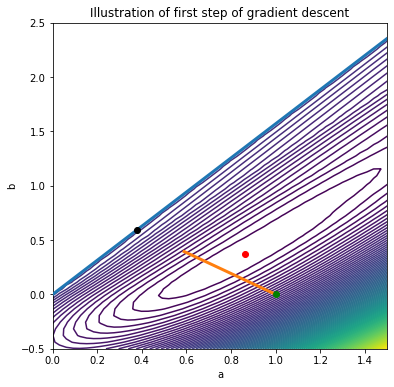

In [32]:
step = -gfun(np.array([1,0]))

_ = plt.subplots(figsize=(6,6))
plt.contour(XX, YY, f_vals2, levels=150, zorder=1)
plt.plot(x1, (np.pi/2)*x1, linewidth=3, zorder=3)
plt.plot([1, 1 + step[0]], [0, step[1]], linewidth=3, zorder=3)
plt.scatter(1, 0, c='g', zorder=4)
plt.scatter(m[0], m[1], c='r', zorder=4)
plt.scatter(intersection[0], intersection[1], c='k', zorder=4)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Illustration of first step of gradient descent')
plt.savefig('../pics/gd_firststep.png')
plt.show()

In [27]:
slope = step[1]/step[0]
lhs = np.array([[slope, -1], [np.pi/2, -1]])
rhs = np.array([slope, 0])
intersection = np.linalg.solve(lhs, rhs)
intersection

array([0.37958407, 0.59624926])

In [35]:
d = np.sqrt((intersection[0] - 1)**2 + intersection[1]**2)
astar = d/np.linalg.norm(step)
astar

1.5099602410260964

In [43]:
alphas = astar*np.linspace(0.8, 0.9, num=40)
results = np.zeros(alphas.shape)
for i in range(results.shape[0]):
    _, indicator = GD(x0, gfun, alpha=alphas[i], cutoff=True)
    results[i] = 1 if indicator > 1000 else 0
    

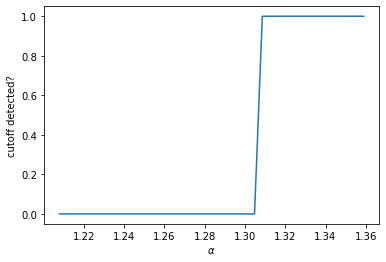

In [45]:
plt.plot(alphas, results)
plt.xlabel(r'$\alpha$')
plt.ylabel('cutoff detected?')
plt.savefig('../pics/cutoffs.png')
plt.show()

## Part 3

In [1]:
def SGD(x0, gfun, schedule='recip', tol=1e-6, maxiter=250, lr=alpha*0.8, r=5, M=20):
    # Stochastic gradient descent function with batch size 1
    # Input: x0   = initial guess
    #        gfun = gradient of function accepting index to report at

    x = x0
    n = train_pts.shape[0]
    iterrange = range(maxiter)

    # Set stepsize reduction strategy
    if schedule == 'recip':
        alpha = [lr/(iter + 1) for iter in iterrange]
    elif schedule == 'power':
        alpha = [lr*2**(-iter-1) for iter in iterrange]
    elif schedule == 'exp':
        alpha = [lr*np.exp(-r*iter) for iter in iterrange]
    elif schedule == 'drop':
        alpha = [lr*r**(iter/M) for iter in iterrange]
    elif schedule == 'cons':
        alpha = [lr for iter in iterrange]
    else: raise RuntimeError('unimplemented scheduler')

    losses = np.zeros((len(iterrange)))
    for iter in iterrange:
        xp = x
        idx = np.random.randint(0, n)  # generate random batch
        gp = gfun(xp, I=idx)
        x = xp - alpha[iter]*gp

        losses[iter] = np.linalg.norm(gp)
        if iter > 0 and losses[iter] < tol: break
    
    return x, losses

NameError: name 'alpha' is not defined

In [432]:
x, _ = SGD(x0, gfun, lr=1, schedule='recip', tol=1e-15)
x

array([0.95273399, 0.09250633])

In [167]:
SGD(np.array([1, 0]), gfun, schedule='cons', r=0.1)

array([0.86128901, 0.37349154])

In [399]:
x0 = np.array([1, 0])
schedule_res = dict.fromkeys(['recip', 'power', 'exp', 'drop', 'cons'], {})
lrs = np.linspace(0.05, 5.1, num=100)
for schedule in schedule_res:
    for i in trange(lrs.shape[0]):
        _, losses = SGD(x0, gfun, lr=lrs[i], schedule=schedule, maxiter=5000)
        schedule_res[schedule][i] = losses

100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


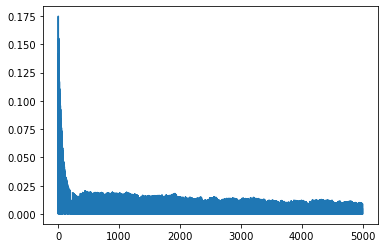

In [406]:
plt.plot(schedule_res['recip'][0])
plt.show()